# SLT-CE-7: Mean Field Approximation

**Solve the main part of the exercise to get 1 point. Solve the extension as well to get 2 points.**

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[4] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[5] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [4]. However, to approximate the inference, instead of using MCMC, we will apply mean field approximation and then compare it to the MCMC estimates.

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

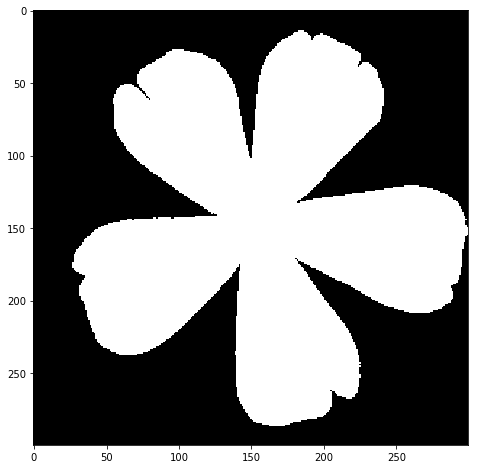

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

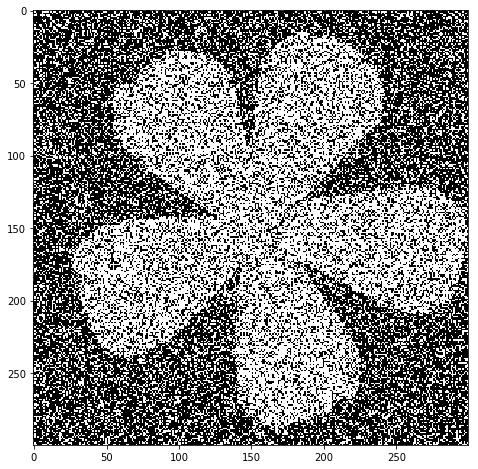

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as given in [2].

In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

Estimating loss via mean squared error

In [9]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [10]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [11]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300856.0


## Problem 0

Describe the basics of the mean field approximation:
### Objective
We have some given posterior distribution $p(x|y)$ which is intraceable. So what we can do is we think of an approx. distribution $q(x)$ with which we want to approximate $p(x|y)$. This is then turned into an optimization problem by saying that we choose the parameters of our proposal distribution by $min D_{q} (p || q)$. Since p is still not traceable normally what is done is to switch p & q and then replace p by $\hat{p} = Zp$ which results in $min D_{q} (q || p)- log(Z)$ and the constant will just fall out so that we're left with 2 traceable distributions. 
### Connection to mean field 
In the mean field method we assume for our approx. distribution that it is fully factorizable: $q(x) = \prod_{i=1}^N q_i(x_i;u_i)$. So our objective becomes $min_{q_1, ..., q_N} D_{KL} (q || p )$.
This results then commonly in an update rule in style of: $log q_j(x_j)=E_{-q_j}[log \hat p(x)] + const$. By $-q_j$ is meant expectation over all except when $i==j$.Also to note is that the factorization happens normally more like a conditional independance by the parameter $u_i$ that is derived from the neighbors of $x_i$

## Problem 1

With the help of [2], explain the algorithm for solving image denoising using mean field approximation. <br>


## Problem 2

Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.

Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?

Consider running the comparison on another image to prove your point.

Also, feel free to replace our implementation of MCMC with your own.

In [76]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

In [77]:
from scipy.signal import correlate2d
from scipy.stats import norm

def meanfield(img_noisy_observation, img_original, epochs):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    
    # initialize params
    sigma = 2 
    lambdaz = 0.5
    img_noisy_observation = img_noisy_observation.copy()
    # this is unnormalized since the normalized can't be approx. see notes above. 
    # log(ṕ(x)) = log(Zp(x)) = log(Z) + log(p(x)) 
    # where p(x) = sum_i sum_j W_ij x_i x_j with j neighbor of i
    def log_prior(x):

        kernel = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])
        result = correlate2d(x, kernel, mode='same')
        return result
    
    print(log_prior(img_noisy_observation))
    

    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(epochs):
        logodds = np.log(norm.pdf(img_noisy_observation, loc=1, scale=2)) - np.log(norm.pdf(img_noisy_observation, loc=-1, scale=2))
        img_noisy_observation = (1 - lambdaz) * img_noisy_observation + lambdaz * np.tanh(log_prior(img_noisy_observation) + .5 * logodds)

        E = energy(img_noisy_observation, img_noisy_observation)
        L = mse_loss(img_noisy_observation, img_original)
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)


In [78]:
def evaluate(method, img_noisy_observation, img_original, epochs=1):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

In [79]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

TypeError: 'NoneType' object is not iterable

In [ ]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

Compare and analyze performance:

Any implementation/computational/numerical issues?

## Problem 3

Comment on the convergence of the method. How can we tell if the mean field convereged? Do we always reach the global optimum?

## Problem 4

How do the parameters of the Ising model, and the tempereature affect the performance of the mean field?

Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour?

## Problem 5

Is there something specific to the given image, which makes it more suitable for one or the other method? Feel free to use another image to prove your point?

# Extension: Smooth k-means

For this part of the task please use the Wine data set (different one than before, see [3]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means [1] and compare them on the Wine data set.

Implementation:

Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.

Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.

Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters?

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!